In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)
/usr/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
path = '/input/'
batch_size=32

In [3]:
test_batches = get_batches('/output/test', gen=image.ImageDataGenerator(), batch_size=batch_size, shuffle=False, class_mode=None)

Found 12500 images belonging to 1 classes.


In [4]:
test_filenames = test_batches.filenames
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]

In [5]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
import cv2
import os
from sklearn.neighbors import NearestNeighbors

**Histagram Analysis**

https://www.kaggle.com/xenocide/the-nature-conservancy-fisheries-monitoring/fishy-neighbors-knn-solution-log-loss-1-65074

Here I set BINS to 8.

In [7]:
def extract_color_histogram(image,bins = (8,8,8)):
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv],[0,1,2],None,bins,[0,180,0,256,0,256])
    cv2.normalize(hist,hist)
    return hist.flatten()

In [8]:
test_filenames[:5]

['unknown/10592.jpg',
 'unknown/7217.jpg',
 'unknown/3653.jpg',
 'unknown/4382.jpg',
 'unknown/2924.jpg']

In [10]:
hists = []
for i,image_path in enumerate(test_filenames):
    image = misc.imread('/output/test/'+image_path)
    image = cv2.resize(image,(224,224)) 
    hist = extract_color_histogram(image)
    hists.append(hist)
    if (i+1)%1000 == 0:
        print (i)

999
1999
2999
3999
4999
5999
6999
7999
8999
9999
10999
11999


In [11]:
np.array(hists).shape

(12500, 512)

In [12]:
N = 3
knn = NearestNeighbors(N)

In [13]:
knn.fit(np.array(hists))

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=3, p=2, radius=1.0)

# Visualize knn Results#

Show test_filename[0] and its nearest 2 images

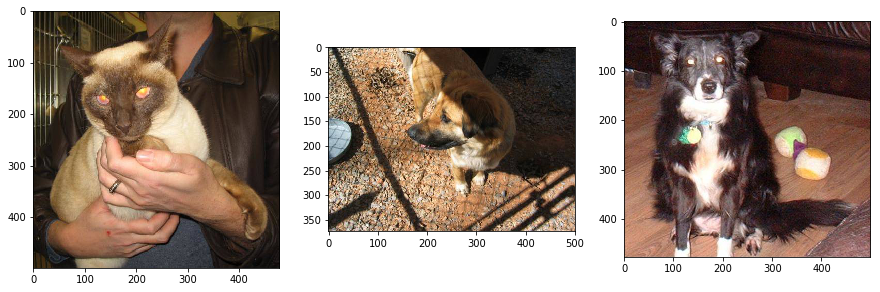

In [62]:
img_ind = 0
test_img_path = '/output/test/'+test_filenames[img_ind]
X = misc.imread(test_img_path)
X = cv2.resize(X,(224,224))
X = extract_color_histogram(X)
nearest_3 = knn.kneighbors(X.reshape(1,-1), return_distance=False) # Use X.reshape(1,-1) instead of X to prevent warning message

N = 3
plt.figure(figsize=(15,15))
for i in range(len(nearest_3[0])):
    img = misc.imread('/output/test/'+test_filenames[nearest_3[0,i]])    
    subp_ind = 100+N*10+i+1
    plt.subplot(subp_ind)
    plt.imshow(img)
plt.show()

Similar in color distribution doesn't mean same species.

knn blending seems not working in the data set

In [20]:
from numpy import genfromtxt
import numpy as np
import pandas as pd

In [21]:
sub1 = genfromtxt('arith_mean_subm_clip.csv', delimiter=',')

In [22]:
sub1[:5]

array([[         nan,          nan],
       [  1.0592e+04,   2.8600e-03],
       [  7.2170e+03,   2.8600e-03],
       [  3.6530e+03,   9.8000e-01],
       [  4.3820e+03,   4.9200e-03]])

In [29]:
sub1_isDog = sub1[1:]
sub1_isDog = sub1_isDog[:,1:]

Submission before knn blending

In [30]:
sub1_isDog[:5]

array([[ 0.0029],
       [ 0.0029],
       [ 0.98  ],
       [ 0.0049],
       [ 0.6665]])

    nearest_3_of_fn: a dicitonary that stores {filename[id]: filenames of imgs that are nearest to filename[id]}

In [55]:
preds_avg_subm1 = np.zeros((sub1_isDog.shape[0],1))
nearest_3_of_fn = {}

In [63]:
num_imgs = sub1_isDog.shape[0]

for i in range(num_imgs):
    #test_img_path = '/output/test/'+test_filenames[i]
    #X = misc.imread(test_img_path)
    #X = cv2.resize(X,(224,224))
    #X = extract_color_histogram(X)
    nearest_3_of_fn[test_filenames[i]] = knn.kneighbors(hists[i].reshape(1,-1), return_distance=False)[0]
    
    sum_nearest_3_subm1 = 0
    for n in nearest_3_of_fn[test_filenames[i]]:
        sum_nearest_3_subm1 = sum_nearest_3_subm1 + sub1_isDog[n]
        
    avg_nearest_3_subm1 = sum_nearest_3_subm1/3.
    
    preds_avg_subm1[i,:] = avg_nearest_3_subm1
    
    if (i+1)%1000 == 0:
        print (i+1)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


Submission after blending

In [64]:
preds_avg_subm1[:5]

array([[ 0.6527],
       [ 0.3291],
       [ 0.6543],
       [ 0.3293],
       [ 0.5498]])

Not a good blended result.